In [12]:
from picamera.array import PiYUVArray, PiRGBArray
from picamera import PiCamera

from scipy.signal import find_peaks, butter, filtfilt
import time
import matplotlib.pyplot as plt
import skimage as ski
import numpy as np
import RPi.GPIO as GPIO

# Camera resolution
res = (640, 480)

CAMERA_CENTER = res[0] // 2
       
from pwm import PWM

# Light and beep init

In [13]:
def init_LED():
    GPIO.setmode(GPIO.BOARD)
    GPIO.setup(16, GPIO.OUT)
    GPIO.output(16, GPIO.LOW)
    GPIO.setup(18, GPIO.OUT)
    GPIO.output(18, GPIO.LOW)
    
def LED_left():
    GPIO.output(16, GPIO.HIGH)
def LED_right():
    GPIO.output(18, GPIO.HIGH)
    
def init_Buzzer():
    GPIO.setmode(GPIO.BOARD)
    GPIO.setup(11, GPIO.OUT)
    GPIO.output(11, GPIO.HIGH)
    
def Beep():
    GPIO.output(11, GPIO.LOW)
    
def NoBeep():
    GPIO.output(11, GPIO.HIGH)

## Setup servo and motor PWM signal to control the steering angle and the speed.

The values specified period and duty cycle ar in nanoseconds.

Servo and motor controlled follow the following protocol:
  1. Control signal is read 50 times per second by each device (servo and speed controller). Thus period is 20 ms => 20000000 ns
  2. To send the minimum value (full left for servo and break for motor) the duty cycle should be 1 ms => 1000000 ns
  3. Maximum value corresponds to a duty cycle of 2 ms => 2000000 ns
  
However, these devices are not perfect and you can set a duty cycle outside this range and still get a response. I would recoment to play with it and find are the limits in your case. Pay attention that servo is limited by the mechanical construction how much it can turn the wheels. Do not set these limits to a value which servo cannot execute as it will try to do that and eventually burn.

In [14]:
# Enable servo
SERVO_MIDDLE = 1650000

servo = PWM(1)
servo.period = 20000000
servo.duty_cycle = SERVO_MIDDLE
servo.enable = True

In [15]:
# Enable motor
MOTOR_BRAKE = 1000000

motor = PWM(0)
motor.period = 20000000
motor.duty_cycle = MOTOR_BRAKE
motor.enable = True

In [16]:
img_history = []
action = []

In [17]:
motor.duty_cycle = MOTOR_BRAKE 

In [22]:
# Release resources
stream.close()
rawCapture.close()
camera.close()
motor.duty_cycle = MOTOR_BRAKE   

## The self driving code

Quick explanation on how this algorithm works:
  1. Initialize the camera, use a frame rate of 10 to 20 fps
  2. Get the coefficients of the butterworth filter of order 3 and cut-off frequency of 0.1 (change cut of frequency if the peak functions is not working)
  3. For each frame captured from the camera:
    1. Get the blak and white part of the image
    2. Select line 195 to use for lane detection (this number depends on your camera angle)
    3. Filter the line and find the peaks that are greater than 160. White parts of the image have higher values than the black. The threshold of 160 depends on the ambient light, lower if the room is darker
    4. Find the peaks left and right of the camera center, these peaks should corresponds to the white lines delimiting the track,
    5. Compute the center point between these lines. This is where we want our car
    6. Compute the error by substracting the center point from camera middle and multiply by 5000. 5000 is our P gain.
    7. Adjust the duty cycle of the servo such that the

In [23]:
# Run a track detection algorithm on a single horizontal line.
# Uses YUV420 image format as the Y component corresponds to image intensity (gray image)
# and thus there is no need to convert from RGB to BW

init_LED()
init_Buzzer()

RUN_TIMER = 20 # seconds
history=[]
capture_data = True

init_v = MOTOR_BRAKE #+ 170000
accelerate = 0#20000

camera = PiCamera()
        
# Check the link below for the combinations between mode and resolution
# https://picamera.readthedocs.io/en/release-1.13/fov.html#sensor-modes
camera.sensor_mode = 7
camera.resolution = res
camera.framerate = 90

# Initialize the buffer and start capturing
rawCapture = PiYUVArray(camera, size=res)
stream = camera.capture_continuous(rawCapture, format="yuv", use_video_port=True)

# Measure the time needed to process 300 images to estimate the FPS
t = time.time()

# To filter the noise in the image we use a 3rd order Butterworth filter

# Wn = 0.02, the cut-off frequency, acceptable values are from 0 to 1
b, a = butter(3, 0.1)

line_pos    = CAMERA_CENTER
first_frame = True
single_line_left = False
single_line_right = False

# start car
motor.duty_cycle = init_v
Beep()
for f in stream:
    t1 = time.time()
#     print("ansdlkasndl")
#     plt.imshow(f)
#     plt.show()
#     break
    
    if first_frame:
        first_frame = False
        # Reset the buffer for the next image
        rawCapture.truncate(0)
        continue
    
    # Stop after RUN_TIMER seconds
    if (time.time() - t) > RUN_TIMER:
        break
        
    # Get the intensity component of the image (a trick to get black and white images)
    I = f.array[:, :, 0]
    if capture_data:
        img_history.append(I)
#     plt.imshow(I)
#     plt.show()
#     break
    # Reset the buffer for the next image
    rawCapture.truncate(0)
    
    # Select a horizontal line in the middle of the image
    L = I[270, :]

    # Smooth the transitions so we can detect the peaks 
    Lf = filtfilt(b, a, L)
    history.append(Lf)

    # Find peaks which are higher than 0.5
    p = find_peaks(Lf, height=160)
    
    peaks = p[0]
    
    line_left   = None
    line_right  = None
    peaks_left  = peaks[peaks < CAMERA_CENTER]
    peaks_right = peaks[peaks > CAMERA_CENTER]

    if peaks_left.size:
        line_left = peaks_left.max()

    if peaks_right.size:
        line_right = peaks_right.min()
        
    if line_left and line_right:
        single_line_left = False
        single_line_right = False
        init_LED()
        motor.duty_cycle = init_v + accelerate
        
        print("both")
        line_pos    = (line_left + line_right ) // 2
        track_width = line_right - line_left
        
        
    elif line_left and not line_right:
        single_line_right = False
        single_line_left = True
        print("left lane")
        init_LED()
        LED_right()
        motor.duty_cycle = init_v
        line_pos    = line_left + int(track_width / 2)
        
    elif not line_left and line_right:
        single_line_left = False
        single_line_right = True
        print("right lane")
        init_LED()
        LED_left()
        motor.duty_cycle = init_v
        line_pos    = line_right - int(track_width / 2)
        
    else:
        #single_line = True
        motor.duty_cycle = init_v
        print("no line")
        
    print(line_pos, peaks)

    if single_line_left:
        DUTY_CYCLE = SERVO_MIDDLE - 600000
    elif single_line_left:
        DUTY_CYCLE = SERVO_MIDDLE - 600000
    else:
        DUTY_CYCLE = SERVO_MIDDLE + 7000 * (CAMERA_CENTER - line_pos)
    if DUTY_CYCLE > 2250000:
        DUTY_CYCLE = 2250000
    if DUTY_CYCLE < 1050000:
        DUTY_CYCLE = 1050000
        
    servo.duty_cycle =  DUTY_CYCLE
    
    
    if capture_data:
        action.append(CAMERA_CENTER - line_pos)
    
    #print(time.time()-t1)
        
#Initialize lines position
#Check which lines are closer them in the next frame

        
        #print(line_pos)
        
motor.duty_cycle = MOTOR_BRAKE    
    

# Release resources
stream.close()
rawCapture.close()
camera.close()
Beep()

left lane
189 [105]
left lane
189 [105]
left lane
189 [105]
left lane
189 [105]
both
315 [105 525]
left lane
311 [101]
left lane
379 [105 169]
left lane
380 [105 170]
left lane
315 [105]
left lane
315 [105]
left lane
314 [104]
left lane
315 [105]
left lane
314 [104]
no line
314 []
no line
314 []
no line
314 []
right lane
338 [548]
no line
338 []
left lane
308 [98]
left lane
309 [99]
left lane
311 [101]
left lane
312 [102]
no line
312 []
no line
312 []
no line
312 []
no line
312 []
no line
312 []
no line
312 []
no line
312 []
no line
312 []
left lane
314 [104]
left lane
315 [105]
left lane
314 [104]
left lane
376 [105 166]
left lane
379 [105 169]
left lane
379 [105 169]
left lane
379 [105 169]
left lane
380 [105 170]
left lane
380 [105 170]
left lane
380 [105 170]
left lane
379 [105 169]
left lane
379 [104 169]
left lane
379 [105 169]
left lane
379 [105 169]
left lane
315 [105]
left lane
314 [104]
left lane
309 [99]
no line
309 []
no line
309 []
no line
309 []
no line
309 []
no line
309

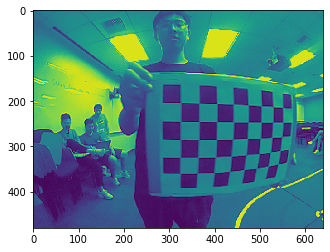

In [24]:
plt.imshow(img_history[120])
plt.show()

In [26]:
import pickle
f= open('jibian.pkl', 'rb')
a = pickle.load(f)
a
#pickle.dump(img_history,f)

[array([[37, 36, 31, ..., 49, 51, 51],
        [37, 37, 33, ..., 49, 53, 52],
        [38, 38, 36, ..., 47, 49, 51],
        ...,
        [12, 10, 10, ..., 26, 24, 23],
        [11, 11,  9, ..., 26, 25, 23],
        [ 6,  6,  5, ..., 26, 26, 26]], dtype=uint8),
 array([[61, 62, 63, ..., 85, 87, 82],
        [63, 62, 65, ..., 85, 88, 82],
        [73, 69, 65, ..., 86, 87, 87],
        ...,
        [18, 18, 12, ..., 57, 56, 52],
        [ 9,  9, 13, ..., 50, 48, 50],
        [12,  8, 11, ..., 48, 46, 46]], dtype=uint8),
 array([[103, 108, 112, ...,  48,  47,  49],
        [108, 107, 112, ...,  45,  46,  50],
        [120, 113, 115, ...,  41,  46,  48],
        ...,
        [ 48,  51,  50, ...,  62, 101, 136],
        [ 44,  50,  48, ...,  83, 120, 135],
        [ 39,  43,  46, ...,  89, 130, 137]], dtype=uint8),
 array([[123, 126, 142, ...,  65,  77,  82],
        [124, 128, 139, ...,  79,  76,  77],
        [125, 129, 135, ...,  88,  79,  78],
        ...,
        [ 74,  77,  77, ...,  

In [94]:
print(len(history))
#plt.imshow(history[0])
#plt.show()

414


new alg

In [10]:
# Run a track detection algorithm on a single horizontal line.
# Uses YUV420 image format as the Y component corresponds to image intensity (gray image)
# and thus there is no need to convert from RGB to BW

RUN_TIMER = 5 # seconds
history=[]

camera = PiCamera()
        
# Check the link below for the combinations between mode and resolution
# https://picamera.readthedocs.io/en/release-1.13/fov.html#sensor-modes
camera.sensor_mode = 7
camera.resolution = res
camera.framerate = 10

# Initialize the buffer and start capturing
rawCapture = PiYUVArray(camera, size=res)
stream = camera.capture_continuous(rawCapture, format="yuv", use_video_port=True)

# Measure the time needed to process 300 images to estimate the FPS
t = time.time()

# To filter the noise in the image we use a 3rd order Butterworth filter

# Wn = 0.02, the cut-off frequency, acceptable values are from 0 to 1
b, a = butter(3, 0.1)

line_pos    = CAMERA_CENTER
first_frame = True

# start car
motor.duty_cycle = MOTOR_BRAKE + 200000

turn = False
for f in stream:
#     print("ansdlkasndl")
#     plt.imshow(f)
#     plt.show()
#     break
    
    if first_frame:
        first_frame = False
        # Reset the buffer for the next image
        rawCapture.truncate(0)
        continue
    
    # Stop after RUN_TIMER seconds
    if (time.time() - t) > RUN_TIMER:
        break
        
    # Get the intensity component of the image (a trick to get black and white images)
    I = f.array[:, :, 0]
#     plt.imshow(I)
#     plt.show()
#     break
    # Reset the buffer for the next image
    rawCapture.truncate(0)
    
    # Select a horizontal line in the middle of the image
    L = I[100, :]

    # Smooth the transitions so we can detect the peaks 
    Lf = filtfilt(b, a, L)
    history.append(Lf)

    # Find peaks which are higher than 0.5
    p = find_peaks(Lf, height=160)
    
    peaks = p[0]
    
    line_left   = None
    line_right  = None
    peaks_left  = peaks[peaks < CAMERA_CENTER]
    peaks_right = peaks[peaks > CAMERA_CENTER]

    if peaks_left.size:
        line_left = peaks_left.max()

    if peaks_right.size:
        line_right = peaks_right.min()
        
    if line_left and line_right:
        turn = False
        line_pos    = (line_left + line_right ) // 2
        track_width = line_right - line_left
        
    elif line_left and not line_right:
        line_pos    = line_left + int(track_width / 2)
        
    elif not line_left and line_right:
        line_pos    = line_right - int(track_width / 2)
        
    else:
        print("no line")
        
    #print(line_pos, peaks)
    if CAMERA_CENTER - line_pos != 0:
        turn = True
        
    DUTY_CYCLE = SERVO_MIDDLE + 5000 * (CAMERA_CENTER - line_pos)
    if DUTY_CYCLE > 2000000:
        DUTY_CYCLE = 2000000
    if DUTY_CYCLE < 1000000:
        DUTY_CYCLE = 1000000
        
    servo.duty_cycle =  DUTY_CYCLE
        
#Initialize lines position
#Check which lines are closer them in the next frame

        
        #print(line_pos)
        
motor.duty_cycle = MOTOR_BRAKE    
    

# Release resources
stream.close()
rawCapture.close()
camera.close()

no line
no line
no line
no line
no line
no line
no line
no line
no line
no line
no line
no line
no line
no line
no line
no line


In [41]:
# Release resources
stream.close()
rawCapture.close()
camera.close()
motor.duty_cycle = MOTOR_BRAKE   

In [36]:
import pickle
print(len(img_history))

0


In [ ]:
plt.imshow(I)
print(peaks)

In [ ]:

peaks = p[0]

line_left   = None
line_right  = None
peaks_left  = peaks[peaks < CAMERA_CENTER]
peaks_right = peaks[peaks > CAMERA_CENTER]

if peaks_left.size:
    line_left = peaks_left.max()
    
if peaks_right.size:
    line_right = peaks_right.min()
    
p

In [ ]:
L = I[200, :]
b, a = butter(3, 0.1)
Lf = filtfilt(b, a, L)

plt.plot(L)
plt.plot(Lf)

In [ ]:
plt.imshow(np.vstack(history))